# Applications of scheduling and assignment problems in operations analytics
## Bus Scheduling Optimization using Linear Programming


University of Niagara Falls Canada

DAMO 610 Operations analytics

Winter 2025

---

## Group 6
**Mario Zamudio** (NF1002499)

**Aarsh Parmar** (NF1012375)

**Ravi Sah** (NF1009324)

---

This notebook implements and analyzes a Linear Programming (LP) model for optimizing urban public bus transport schedules.

The code is based on the research article:

**Modeling and Analysis of Bus Scheduling Systems of Urban Public Bus Transport** by Eshetie Berhan et al. (2014)

The goal is to assign two types of buses (Type-I and Type-II) optimally to 93 city routes over four daily shifts, minimizing the total number of trips while satisfying passenger demand and operational constraints.

---

In [1]:
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math

## Parameters Configuration
These parameters define the problem space, including the number of routes, shifts, bus capacities, and average demand.  These parameters are essential inputs to define the scale and structure of the optimization model, and calculate demand ($D[i][j]$) and trip limits ($T[i][j]$).
Set realistic constraints aligned with the study in the PDF.

_NUM_ROUTES:_ Indicates the number of bus routes under consideration. According to the article, the model focuses on the first 93 out of 110 routes operated by ACBSE.

_NUM_SHIFTS:_ The number of operational shifts (time periods) in a day.
* Morning Peak
* First Off-Peak
* Evening Peak
* Second Off-Peak

_FLEET_TYPE1 and FLEET_TYPE2:_ The total number of available buses.
* Type-I buses (600 units): Each with 30 seats + standing capacity = 60 passengers total
* Type-II buses (90 units): Each with 45 seats + standing = 90 passengers total

_SEAT_CAPACITY_TYPE1 and SEAT_CAPACITY_TYPE2:_ The total capacity per bus type (including standing space), used to calculate if passenger demand is met.

_SHIFT_DURATIONS:_ Duration of each of the 4 shifts in minutes.
* Shift 1: 195 minutes (Morning Peak)
* Shift 2: 360 minutes (Off-Peak)
* Shift 3: 240 minutes (Evening Peak)
* Shift 4: 90 minutes (Late Off-Peak)

_DEMAND_PROPORTIONS:_ Proportion of daily demand allocated to each shift.
* 40% during Morning Peak
* 20% during Midday
* 35% during Evening Peak
* 5% during Late Evening

_BASE_ROUTE_DEMAND:_ Assumed average daily passenger demand per route. This is a base figure multiplied by the shift proportions.

_TRIP_DURATION:_ Assumed duration of a round trip on any route is 30 minutes. This is used to calculate how many trips can be made per bus per shift.

In [2]:
# -------------------------
# Configurable Parameters
# -------------------------
NUM_ROUTES = 93
NUM_SHIFTS = 4
FLEET_TYPE1 = 600  # Bus type-I (30 seats, 60 capacity)
FLEET_TYPE2 = 90   # Bus type-II (45 seats, 90 capacity)
SEAT_CAPACITY_TYPE1 = 60
SEAT_CAPACITY_TYPE2 = 90
SHIFT_DURATIONS = [195, 360, 240, 90]  # in minutes
DEMAND_PROPORTIONS = [0.4, 0.2, 0.35, 0.05]  # for each shift
BASE_ROUTE_DEMAND = 1000  # average daily demand per route
TRIP_DURATION = 30  # one round trip time in minutes

## Derived or Calculated Parameters
This code block computes the derived parameters from the initial configuration. These are key elements used in the Linear Programming (LP) model to define constraints and ensure demand is met across routes and shifts.

**_$w[j]:$_** represents the minimum number of trips that must be made in shift j to ensure a bus is available at least every 30 minutes.
* Computation: For each shift duration d, divide it by TRIP_DURATION (30 min).
* This ensures one trip every 30 minutes, which aligns with the service quality standard mentioned in the article.

Example:

For a 195-minute shift → $195 // 30 = 6$, so at least 6 trips are needed in that shift to meet frequency expectations.

**_$T[i][j]$_** is the trip factor: maximum number of trips a bus can make on route i during shift j.  It assumes all routes have the same travel time (30 minutes), so this ends up as a repeated value for every route.

Example:

If shift 2 is 360 minutes → $360 // 30 = 12$, so a bus can make up to 12 trips in that shift.

**_$P[i]$_** is the trip proportion assigned to route i.  Since the model assumes uniform demand distribution across all 93 routes, each route gets an equal share of total trips. Every route has a proportion of $1/93 ≈ 0.01075 (∑P = 1)$. This is used in constraints that limit trip allocations by fleet size.

**_$D[i][j]$_** is the passenger demand for route i during shift j.  For every route i, the base daily demand (1000) is split into 4 values according to the demand proportions per shift.

Example:  For any route

* Morning peak: $1000 * 0.4 = 400$
* First off-peak: $1000 * 0.2 = 200$
* Evening peak: $1000 * 0.35 = 350$
* Second off-peak: $1000 * 0.05 = 50$
    
So, $D[i] = [400, 200, 350, 50]$ for all i.

In [3]:
# Derived Parameters
w = [d // TRIP_DURATION for d in SHIFT_DURATIONS]  # minimum trips per shift
T = [[d // TRIP_DURATION for d in SHIFT_DURATIONS] for _ in range(NUM_ROUTES)]  # trip factor per route per shift
P = [1 / NUM_ROUTES for _ in range(NUM_ROUTES)]  # equal trip proportion
D = [[BASE_ROUTE_DEMAND * prop for prop in DEMAND_PROPORTIONS] for _ in range(NUM_ROUTES)]

## Solver Instantiation

This line creates a solver instance using Google OR-Tools (a powerful optimization toolkit).
**'CBC'** stands for _Coin-or Branch and Cut_, an open-source mixed-integer programming (MIP) solver.
The solver will be used to define variables, constraints, and an objective function, and then solve the optimization problem.

In this case, the CBC solver is suitable because:
* The problem is linear and involves integer variables (trip counts).
* It’s efficient for large-scale scheduling problems, like the one described in the article
* It performs well for public transportation-type problems.
* CBC is capable of solving large MILP models efficiently, like this one with $93 routes × 4 shifts × 2 bus types$.

In [4]:
# -------------------------
# Create Solver (CBC for Integer LP)
# -------------------------
solver = pywraplp.Solver.CreateSolver('CBC')
if not solver:
    print("Solver not created!")
    exit(1)

### Decision Variables

This piece of code defines the decision variables for the Integer Linear Programming (ILP) model using the OR-Tools solver. These variables represent the number of trips assigned to each bus type, for every route and shift combination.

Two Python dictionaries, x and y, are created to hold variables:
* $x[i, j]$: Number of trips made by Type-I buses on route i during shift j.
* $y[i, j]$: Number of trips made by Type-II buses on route i during shift j.

For each combination of route i and shift j, the model creates:
* An integer variable for $x[i, j]$ (Type-I trips)
* An integer variable for $y[i, j]$ (Type-II trips)

The variables are bounded from 0 to ∞ (solver.infinity()), meaning we can assign zero or more trips, as long as constraints are satisfied.

These variables are the core of the optimization — the solver will find the best values for all $x[i,j]$ and $y[i,j]$ such that:
* Passenger demand is met
* The number of available buses is respected
* The total number of trips is minimized

In [5]:
# -------------------------
# Variables (integer trips)
# -------------------------
x = {}  # trips by type-I
y = {}  # trips by type-II
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        x[i, j] = solver.IntVar(0, solver.infinity(), f'x_{i}_{j}')
        y[i, j] = solver.IntVar(0, solver.infinity(), f'y_{i}_{j}')

### Objective Function

This piece of code defines the objective function of the optimization model. In this case, the goal is to minimize the total number of bus trips across all routes and shifts, regardless of bus type. In linear programming, the objective function is what the solver tries to optimize—either minimize or maximize—subject to a set of constraints.
$$\text{Minimize } \sum_{i=1}^{93} \sum_{j=1}^{4} x_{ij} + y_{ij}$$
Where:
* $x_{ij}$: Number of trips by Type-I buses on route i during shift j
* $y_{ij}$: Number of trips by Type-II buses on route i during shift j

The sum represents the total number of trips in the system.

**Why Minimize Total Trips?**

* Fewer trips = lower operating costs (fuel, driver time, wear & tear).
* It encourages more efficient scheduling by assigning the right bus type and just enough service to meet demand.
  
This aligns with the paper's goal of improving operational efficiency and reducing cost, while maintaining service quality.

In [6]:
# -------------------------
# Objective: Minimize total trips
# -------------------------
objective = solver.Objective()
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        objective.SetCoefficient(x[i, j], 1)
        objective.SetCoefficient(y[i, j], 1)
objective.SetMinimization()

## Constraints Definition

This block defines the constraints of the optimization problem. Constraints are the rules the solution must obey, and they ensure that the model produces a feasible and realistic bus schedule.

| Constraint # | Purpose | Enforces | 
| ------------ | ------- | -------- | 
| 1	| Demand Satisfaction | Enough capacity per route/shift | 
| 2	| Fleet Capacity | Don’t exceed fleet limits | 
| 3	| Service Frequency | Ensure minimum service levels | 
| 4	| Route-wise Realism | Don’t assign more trips than possible per shift/route | 

These constraints transform a simple optimization into a real-world scheduling model, ensuring feasibility, fairness, and quality of service.

### Demand Satisfaction
Ensure that the passenger demand for every route i and shift j is met or exceeded by the total seat capacity provided. 

Multiply the number of trips by the capacity of each bus type:
* Type-I trips: $60 * x[i,j]$
* Type-II trips: $90 * y[i,j]$

The sum must be $≥$ demand ($D[i][j]$)

Example: 

If route 5 in shift 2 has a demand of 400 passengers, the sum of seats offered by all trips (Type-I and Type-II) must be at least 400.

In [7]:
# -------------------------
# Constraints
# -------------------------
# 1. Demand satisfaction
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        solver.Add(SEAT_CAPACITY_TYPE1 * x[i, j] + SEAT_CAPACITY_TYPE2 * y[i, j] >= D[i][j])

### Fleet Size Limits for Total Trips
Prevent assigning more trips than the total fleet can realistically perform.

* total_available_trips: total number of trips all buses could perform (based on time slots available).
* Multiply fleet size by this number to get a hard limit.
* Enforce:
    * total_trips_x $≤ 600$ buses $×$ total trips they can make
    * total_trips_y $≤ 90$ buses $×$ total trips they can make

This avoids overloading the system beyond its operational capacity.

In [8]:
# 2. Fleet size limits for total trips
total_available_trips = sum(sum(T[i]) for i in range(NUM_ROUTES))
total_trips_x = sum(x[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS))
total_trips_y = sum(y[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS))
solver.Add(total_trips_x <= FLEET_TYPE1 * total_available_trips)
solver.Add(total_trips_y <= FLEET_TYPE2 * total_available_trips)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x000001F5D8B81710> >

### Minimum Required Total Trips
Ensure a minimum level of service (e.g., at least one bus every 30 minutes).

* $w[j]$: minimum number of trips needed in shift j (based on duration and trip time).
* Multiply this by the number of routes → the minimum total trips for quality service.
* The total number of trips (across all buses, routes, and shifts) must meet or exceed this.

This guarantees service frequency.

In [9]:
# 3. Minimum required total trips
total_min_trips = NUM_ROUTES * sum(w[j] for j in range(NUM_SHIFTS))
solver.Add(sum(x[i, j] + y[i, j] for i in range(NUM_ROUTES) for j in range(NUM_SHIFTS)) >= total_min_trips)



<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x000001F5D8BCB810> >

### Maximum Trips Per Route and Shift
Cap the number of trips per route and shift based on how many trips can realistically be made.

* $T[i][j]$: maximum trips a single bus can make on route i, shift j
* $P[i]$: the proportion of total trips allocated to route i
* Multiply:
    * For Type-I: max trips $=$ fleet size $× P[i] × T[i][j]$
    * For Type-II: same logic

This avoids over-assigning trips beyond what’s feasible per route and time window.

In [10]:
# 4. Trips per route per shift <= max available trips
for i in range(NUM_ROUTES):
    for j in range(NUM_SHIFTS):
        solver.Add(x[i, j] <= FLEET_TYPE1 * P[i] * T[i][j])
        solver.Add(y[i, j] <= FLEET_TYPE2 * P[i] * T[i][j])

## Solve Model
It runs the solver, trying to find values for all decision variables ($x[i, j]$ and $y[i, j]$) that:
* Satisfy all constraints
* Minimize the objective function

In [11]:
# -------------------------
# Solve Model
# -------------------------
status = solver.Solve()

## Results and Visualization

This code block handles the post-processing of the solver output—analyzing, summarizing, and visualizing the results only if an optimal solution was found. Here's a short description of each section:

### Summary Statistics
It calculates, for each shift:
* Total trips made (trips_by_shift)
* Demand served (demand_by_shift)
* Number of buses used (buses_by_shift)
* Breakdown by bus type (Type I and II)

Per-route trip assignments and bus utilization

### Data Preparation
Stores all calculated results in NumPy arrays and Pandas DataFrames:
* For creating tables and plotting
* For organizing values by route and shift

### Visualizations
Generates 6 useful plots using matplotlib and seaborn:

| Plot # | Chart Type | Shows |
| ------ | ------ | ------ | 
|1	|Bar Chart	|Total trips by shift|
|2	|Bar Chart	|Total buses used by shift|
|3	|Bar Chart	|Total demand by shift|
|4	|Grouped Bar	|Trips by Type I vs Type II buses|
|5	|Stacked Bar	|Number of buses used by type per shift|
|6	|Heatmap	|Bus utilization % across routes and shifts|

### Summary Table
Creates and prints a DataFrame with:
* Shift labels
* Demand, trips, and buses used (by type and in total)

This offers a clean, high-level summary of how resources are allocated per shift.


Optimal solution found!
Total trips: 2697.0

Trips by shift: [813.0, 829.0, 693.0, 362.0]
Trips by bus type (Type I): [503.0, 542.0, 399.0, 284.0]
Trips by bus type (Type II): [310.0, 287.0, 294.0, 78.0]
Buses by shift: [171, 131, 125, 180]


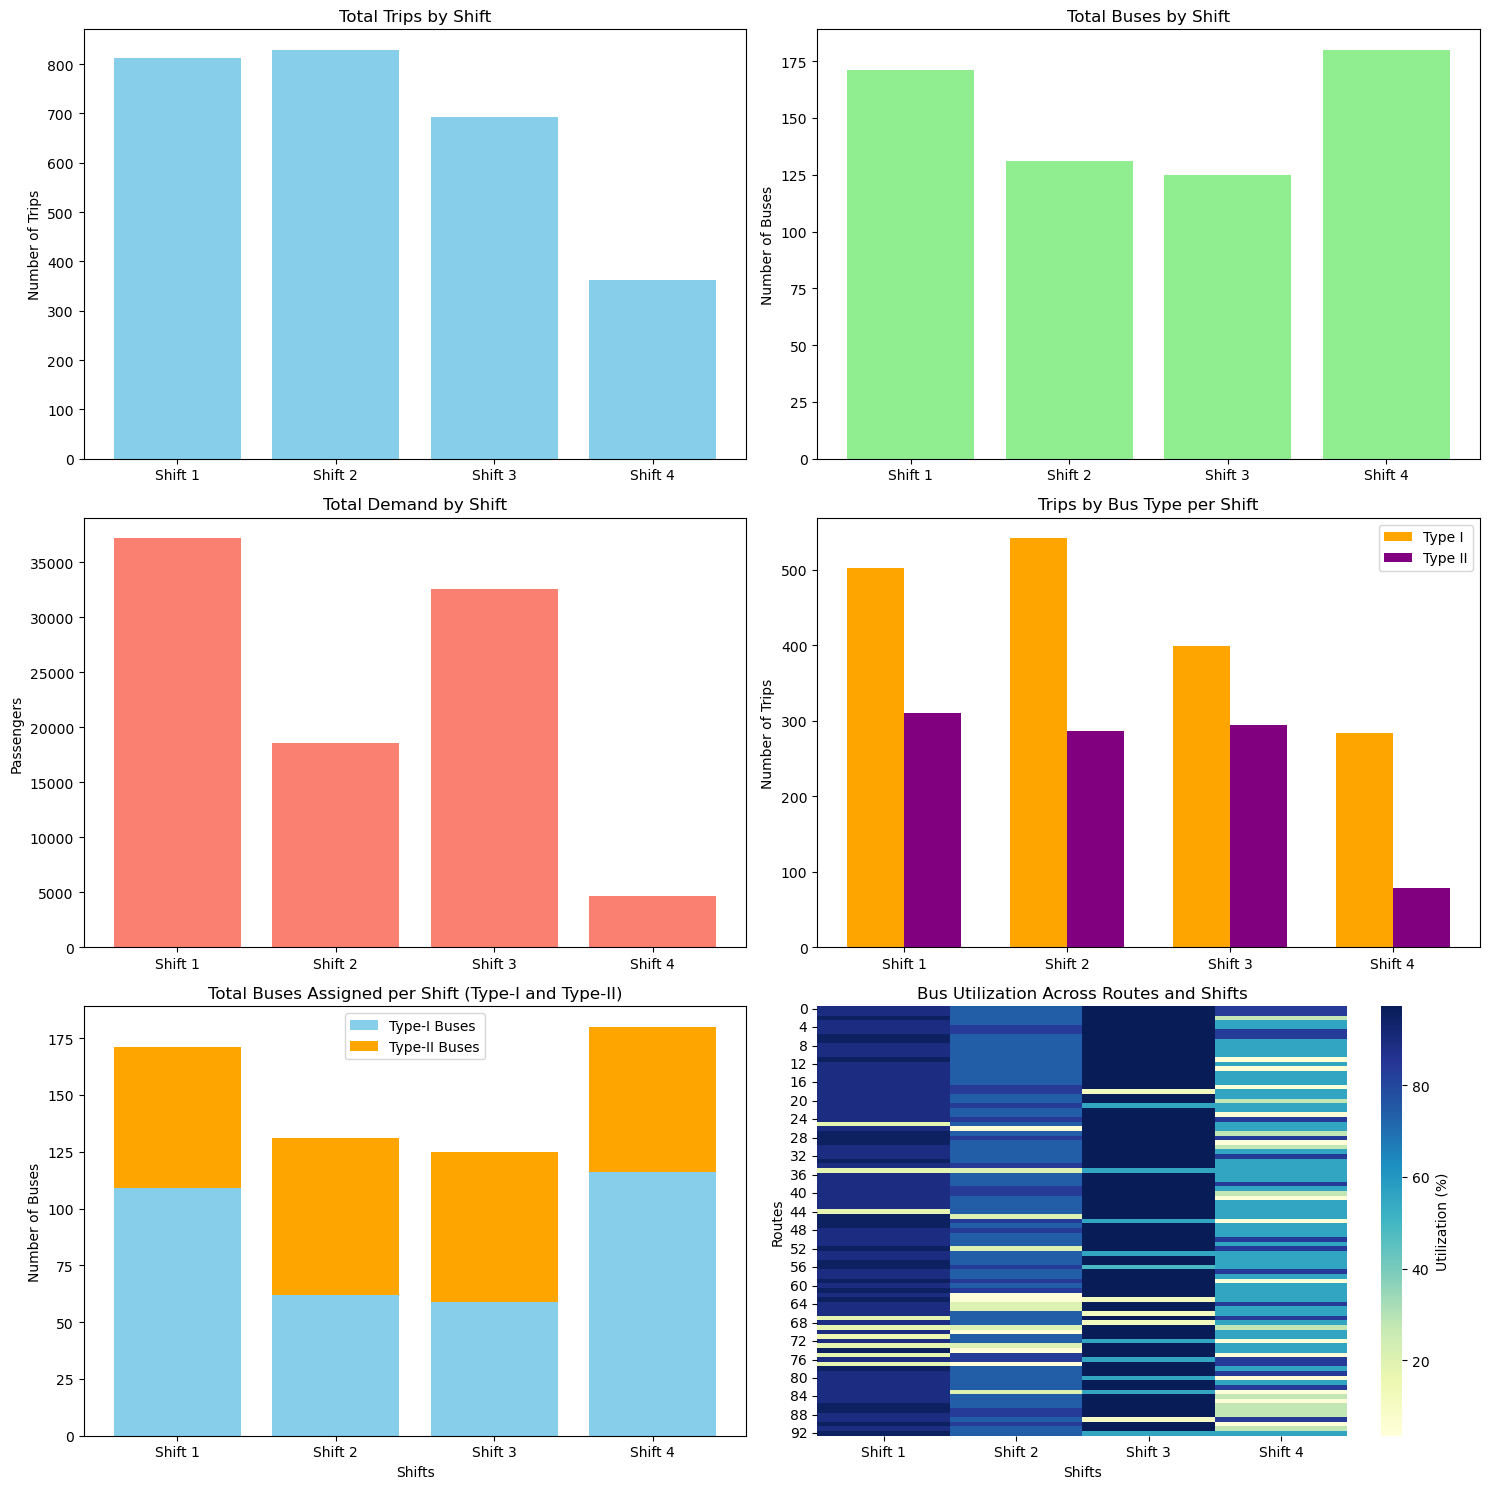


--- Summary Table by Shift ---
  Shift  Demand  Trips (Type I)  Trips (Type II)  Total Trips  Total Buses  Buses (Type I)  Buses (Type II)
Shift 1 37200.0           503.0            310.0        813.0          171           109.0             62.0
Shift 2 18600.0           542.0            287.0        829.0          131            62.0             69.0
Shift 3 32550.0           399.0            294.0        693.0          125            59.0             66.0
Shift 4  4650.0           284.0             78.0        362.0          180           116.0             64.0


In [12]:
# -------------------------
# Results and Visualization
# -------------------------
if status == pywraplp.Solver.OPTIMAL:
    print("\nOptimal solution found!")
    print(f"Total trips: {objective.Value()}")

    # Collect data for visualization
    trips_by_shift = [0] * NUM_SHIFTS
    buses_by_shift = [0] * NUM_SHIFTS
    demand_by_shift = [0] * NUM_SHIFTS
    trips_type1_by_shift = [0] * NUM_SHIFTS
    trips_type2_by_shift = [0] * NUM_SHIFTS
    buses_type1_by_shift = [0] * NUM_SHIFTS
    buses_type2_by_shift = [0] * NUM_SHIFTS

    # Arrays to store per-route-per-shift data for heatmaps
    trips_type1 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    trips_type2 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    buses_type1 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    buses_type2 = np.zeros((NUM_ROUTES, NUM_SHIFTS))
    bus_utilization = np.zeros((NUM_ROUTES, NUM_SHIFTS))

    for i in range(NUM_ROUTES):
        for j in range(NUM_SHIFTS):
            x_val = x[i, j].solution_value()
            y_val = y[i, j].solution_value()
            # Aggregate totals per shift
            trips_by_shift[j] += x_val + y_val
            trips_type1_by_shift[j] += x_val
            trips_type2_by_shift[j] += y_val
            buses_type1_by_shift[j] += math.ceil(x_val / T[i][j])
            buses_type2_by_shift[j] += math.ceil(y_val / T[i][j])
            buses_by_shift[j] += math.ceil(x_val / T[i][j]) + math.ceil(y_val / T[i][j])
            demand_by_shift[j] += D[i][j]
            # Store per-route-per-shift data
            trips_type1[i, j] = x_val
            trips_type2[i, j] = y_val
            buses_type1[i, j] = math.ceil(x_val / T[i][j])
            buses_type2[i, j] = math.ceil(y_val / T[i][j])
            # Calculate bus utilization
            capacity_allocated = (SEAT_CAPACITY_TYPE1 * x_val + SEAT_CAPACITY_TYPE2 * y_val)
            bus_utilization[i, j] = (D[i][j] / capacity_allocated * 100) if capacity_allocated > 0 else 0

    print("\nTrips by shift:", trips_by_shift)
    print("Trips by bus type (Type I):", trips_type1_by_shift)
    print("Trips by bus type (Type II):", trips_type2_by_shift)
    print("Buses by shift:", buses_by_shift)

    # Convert to DataFrames for visualization
    trips_type1_df = pd.DataFrame(trips_type1, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    trips_type2_df = pd.DataFrame(trips_type2, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    buses_type1_df = pd.DataFrame(buses_type1, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    buses_type2_df = pd.DataFrame(buses_type2, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])
    utilization_df = pd.DataFrame(bus_utilization, columns=[f"Shift {j+1}" for j in range(NUM_SHIFTS)])

    # Plotting
    shifts_labels = [f'Shift {i+1}' for i in range(NUM_SHIFTS)]
    plt.figure(figsize=(15, 15))

    # Plot 1: Total Trips by Shift
    plt.subplot(3, 2, 1)
    plt.bar(shifts_labels, trips_by_shift, color='skyblue')
    plt.title('Total Trips by Shift')
    plt.ylabel('Number of Trips')

    # Plot 2: Total Buses by Shift
    plt.subplot(3, 2, 2)
    plt.bar(shifts_labels, buses_by_shift, color='lightgreen')
    plt.title('Total Buses by Shift')
    plt.ylabel('Number of Buses')

    # Plot 3: Total Demand by Shift
    plt.subplot(3, 2, 3)
    plt.bar(shifts_labels, demand_by_shift, color='salmon')
    plt.title('Total Demand by Shift')
    plt.ylabel('Passengers')

    # Plot 4: Trips by Bus Type per Shift
    bar_width = 0.35
    x_indexes = list(range(NUM_SHIFTS))
    plt.subplot(3, 2, 4)
    plt.bar([i - bar_width/2 for i in x_indexes], trips_type1_by_shift, width=bar_width, label='Type I', color='orange')
    plt.bar([i + bar_width/2 for i in x_indexes], trips_type2_by_shift, width=bar_width, label='Type II', color='purple')
    plt.xticks(ticks=x_indexes, labels=shifts_labels)
    plt.title('Trips by Bus Type per Shift')
    plt.ylabel('Number of Trips')
    plt.legend()

    # Plot 5: Total Buses Assigned per Shift (Type-I and Type-II) - Stacked Bar Chart
    total_buses_type1_per_shift = buses_type1_df.sum()
    total_buses_type2_per_shift = buses_type2_df.sum()
    plt.subplot(3, 2, 5)
    plt.bar(shifts_labels, total_buses_type1_per_shift, label="Type-I Buses", color="skyblue")
    plt.bar(shifts_labels, total_buses_type2_per_shift, bottom=total_buses_type1_per_shift, label="Type-II Buses", color="orange")
    plt.title("Total Buses Assigned per Shift (Type-I and Type-II)")
    plt.xlabel("Shifts")
    plt.ylabel("Number of Buses")
    plt.legend()

    # Plot 6: Heatmap of Bus Utilization Across Routes and Shifts
    plt.subplot(3, 2, 6)
    sns.heatmap(utilization_df, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Utilization (%)'})
    plt.title("Bus Utilization Across Routes and Shifts")
    plt.xlabel("Shifts")
    plt.ylabel("Routes")

    plt.tight_layout()
    plt.show()

    # Summary Table
    summary_data = {
        'Shift': shifts_labels,
        'Demand': demand_by_shift,
        'Trips (Type I)': trips_type1_by_shift,
        'Trips (Type II)': trips_type2_by_shift,
        'Total Trips': trips_by_shift,
        'Total Buses': buses_by_shift,
        'Buses (Type I)': total_buses_type1_per_shift,
        'Buses (Type II)': total_buses_type2_per_shift
    }
    summary_df = pd.DataFrame(summary_data)
    print("\n--- Summary Table by Shift ---")
    print(summary_df.to_string(index=False))

else:
    print("No optimal solution found. Status:", status)